# Notebook 8: Neural Networks
This example classifies the digit dataset using a neural network.


To make this run, you need to install PyTorch with `conda install pytorch` or `pip3 install torch` depending on your setup.

### 0. Preamble

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)

The following lines checks for GPU availability on the machine and sets the GPU as processing device (if available).
No worries if you have no GPU available, CPU works also fine for this small example.

In [2]:
if(torch.cuda.is_available()):
  processing_chip = "cuda:0"
  print(f"{torch.cuda.get_device_name(0)} available")
else:
  processing_chip = "cpu"
  print("No GPU available")

device = torch.device(processing_chip)
device

No GPU available


device(type='cpu')

### 1. Data Preperation

We work with the already know digit dataset, where our class is to determine which number is shown on the image. For more details on the dataset, check our previous notebook `2_Logistische_Regression_Digits`.

In [3]:
import pandas as pd
data = pd.read_csv("data/digits.csv")
data.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [4]:
X = data.drop(["label"], axis=1)
y = data["label"]

In [5]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
train_X

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
1109,0.0,0.0,0.0,9.0,15.0,2.0,0.0,0.0,0.0,0.0,...,15.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,6.0
940,0.0,3.0,12.0,12.0,14.0,4.0,0.0,0.0,0.0,1.0,...,8.0,0.0,0.0,2.0,13.0,16.0,16.0,16.0,2.0,0.0
192,0.0,1.0,10.0,15.0,16.0,13.0,3.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,15.0,13.0,7.0,0.0,0.0,0.0
260,0.0,0.0,0.0,12.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,9.0,0.0,0.0,0.0
1148,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,12.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.0,1.0,8.0,14.0,15.0,2.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,1.0,9.0,12.0,13.0,9.0,0.0,0.0
1216,0.0,2.0,9.0,15.0,16.0,15.0,2.0,0.0,0.0,11.0,...,7.0,0.0,0.0,0.0,12.0,16.0,15.0,9.0,1.0,0.0
1653,0.0,0.0,5.0,14.0,14.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,9.0,13.0,0.0,0.0,0.0,0.0
559,0.0,0.0,4.0,10.0,15.0,16.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,16.0,4.0,0.0,0.0,0.0


To be able to use the data in PyTorch, we need to convert our data into PyTorch tensors. Such a tensor can be thought of an efficient way to represent lists and matrices in Python (similar to `numpy`), with the additional benefit that they can be easily copied to the GPU (the `.to(device)` command in the code below) and that they support automatic backpropagation (more on this later):

In [8]:
train_x = torch.Tensor(train_X.values).float().to(device)
test_x = torch.Tensor(test_X.values).float().to(device)
train_y =torch.Tensor(train_y.values).long().to(device)
test_y = torch.Tensor(test_y.values).long().to(device)

### 2. Model definition 


We define now the structure of our neural network. For this we create a class that is a subclass from PyTorch's `nn.Module`. By convention, we put in the `__init__` method (the class constructor) the layers we want to use in the network and in the `forward` method how data flows through this network.

Our network has 64 input features, one hidden layer with 5 neurons and 10 output neurons. The hidden layer uses a Relu activation function. Note that the output layer does not have a softmax activation (unlike we have seen it in the lecture). It rather gives out a raw score for each class (more on this later).

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(64, 5)
        self.output = nn.Linear(5, 10)

    def forward(self, x):
        z = F.relu(self.hidden(x))
        z = self.output(z)  # no softmax. see CrossEntropyLoss()
        return z

### 3. Model Training

We can now start training our network. We run several epochs in which we first predict on the training data with our network (forward pass) and then backpropagate the loss to compute the gradients. For this we use PyTorch's build-in optimizer that runs gradient descent on the weights of the network. Hence, in every episode we reduce the loss on the training data and improve our network.

As loss function we use cross entropy, which consumes the raw scores from the prediction and internally applies a softmax (that is why we do not need the softmax as last layer in the network).

Note that all training data is passed at once to our network (line `net(train_x)` ), since PyTorch will predict on all data points in parallel.

In [18]:
# create network, move it to device and set it to training-mode
net = Net().to(device)
net.train()

# define the parameters for training
no_epochs = 1000
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()
  y_hat = net(train_x)
  loss = loss_func(y_hat, train_y)
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())
  
  if epoch % 100 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 3.410353422164917
Loss in epoch 100 is 1.8052477836608887
Loss in epoch 200 is 1.3742443323135376
Loss in epoch 300 is 1.1726536750793457
Loss in epoch 400 is 1.0254273414611816
Loss in epoch 500 is 0.908483624458313
Loss in epoch 600 is 0.8051084280014038
Loss in epoch 700 is 0.7086776494979858
Loss in epoch 800 is 0.6287705302238464
Loss in epoch 900 is 0.5726308822631836
Done training 


One standard way to monitor the training is to plot the loss after every episode. If this goes constantly down, the training is working.

Text(0, 0.5, 'loss')

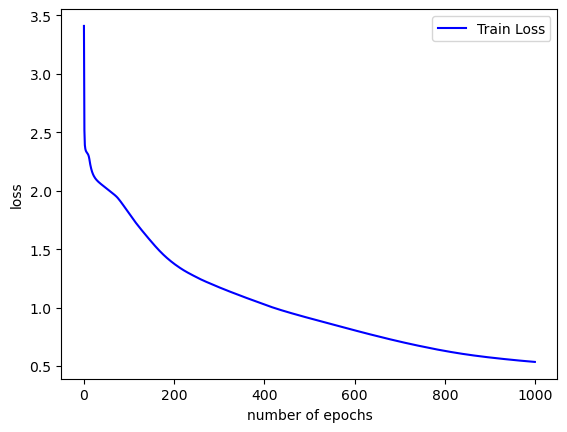

In [19]:
fig = plt.figure()
plt.plot(range(0, no_epochs), train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('loss')

### 4. Model Evaluation

Finally, we check the model accuracy on the test data. For this we predict on the test data, identify the class with the highest score and compare it to the true label.

In [21]:
net.eval() # set network to evaluation mode
y_pred = net(test_x)
print(y_pred[0])
_, predicted = torch.max(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

tensor([ -3.6966,  -0.4506,  10.3469,   3.9279, -16.4903,  -0.3034, -10.2447,
          8.1205,   4.0147,   4.9532], grad_fn=<SelectBackward0>)
Accuarcy is 83.61111111111111%
